In [1]:
%run "part03_data_preparation.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Unnamed: 8   0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Content</p></div>   

* **Settings**
    - Pyplot configurations<br><br>
    
* **Modeling**
    - Kmeans
    - Hierarchical Clustering
    - Gaussian Mixture Model
    - DBScan<br><br>  
    
* **Embedded Space**
    - UMAP
    - t-SNE
    - Random Forest<br><br>
    
* **Evaluating**
    - Choosing Model
    - Creating RFM Table    

In [2]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy

from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors

from plotly.offline import plot, iplot, init_notebook_mode
from plotly import express as px
from plotly.subplots import make_subplots
import plotly as py
import plotly.graph_objs as go
import plotly.io as pio

import dataframe_image as di

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Settings</p></div>

In [4]:
#init_notebook_mode(connected=True)
#pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab

In [5]:
# Setting 2D plot parameters for Plotly
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))

def plot_graph2D(x,y, cluster, title):    
    name=cluster.name
    #data=data.sort_values(by=cluster.name, ascending=True)
    cluster=cluster.astype(str)
    
    fig = px.scatter(#data, 
                     x=x, 
                     y=y, 
                     color=cluster, 
                     color_discrete_sequence=px.colors.qualitative.Prism
                    )

    fig.update_traces(marker=dict(size=11, 
                              opacity=0.75, 
                              line=dict(width=1, color='#F7F7F7')))

    fig.update_layout(template=temp, 
                  title=title, 
                  width=700, 
                  legend_title='Clusters',                  
                  xaxis=dict(title='x', showline=True, zeroline=False), 
                  yaxis=dict(title='y',showline=True, zeroline=False))
    
    
    fig.show()
    
    #pio.write_html(fig, file=f'../images/{name}_{x.name[0:4]}.html', auto_open=False)
    #fig.write_image(f"../images/{name}_{x.name[0:4]}.png")

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Machine Learning Models</p></div>

In this step we will test some classification algorithms using several metrics and we will visualize the results visualize the results on the Cartesian axis using dimensionality reduction techniques such as UMAP and t-SNE.

As the 3d-plot is heavier I just made a graph for illustration.

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Kmeans</p></div>

In [6]:
# Finding best K param to Kmeans, using WCSS and Silhouette Score as metrics
kmeans_scores_list = []

for k in range(2,13):
    tunning_kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)# init="k-means++",       
    tunning_kmeans_labels = tunning_kmeans.fit_predict(X)
    
    ss = silhouette_score(X, tunning_kmeans_labels, metric='euclidean')
    
    dbs = davies_bouldin_score(umap_embedding, tunning_kmeans_labels)
    
    kmeans_scores_list.append(pd.Series({'Clusters': k,
                                    'WCSS': tunning_kmeans.inertia_,
                                    'SS': ss,     
                                    'DBS': dbs}))

In [7]:
kmeans_scores_table = (pd.concat(kmeans_scores_list, axis=1).T[['Clusters','WCSS','SS','DBS']].set_index('Clusters'))

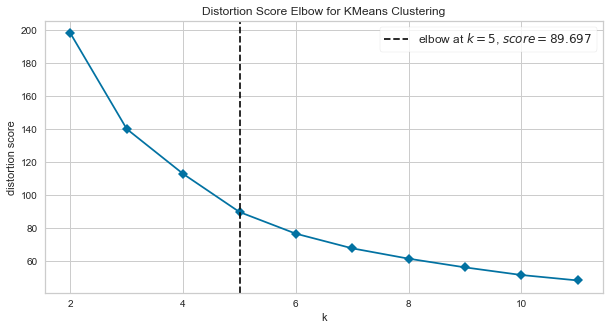

In [8]:
plt.figure(figsize=(10,5))
elbow = KElbowVisualizer(tunning_kmeans, k=(2,12), timings = False)
elbow.fit(X) #, timings = False
elbow.show();

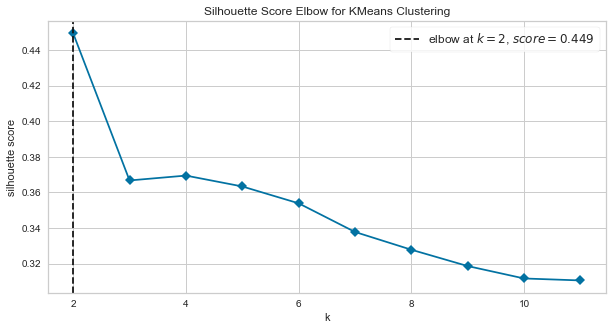

In [9]:
plt.figure(figsize=(10,5))
ss = KElbowVisualizer(tunning_kmeans, k=(2,12), metric = 'silhouette', timings = False)
ss.fit( X )
ss.show();

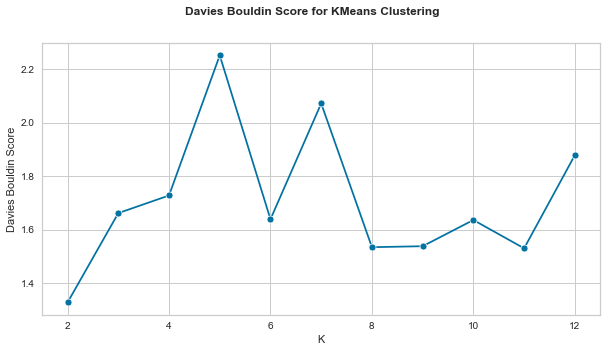

In [10]:
plt.figure(figsize=(10,5))
plt.suptitle('Davies Bouldin Score for KMeans Clustering', fontsize=12, fontweight='bold')
sns.lineplot(x=kmeans_scores_table.index, y=kmeans_scores_table['DBS'], marker='o')
plt.xlabel('K');
plt.ylabel('Davies Bouldin Score');

In [11]:
# Using the best k find to our purpouse
k=5
kmeans = KMeans( n_clusters=k, random_state=3456)#init = "k-means++",
kmeans_labels = kmeans.fit_predict(X)
clusters_results['KMeans-Cluster'] = kmeans_labels

C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



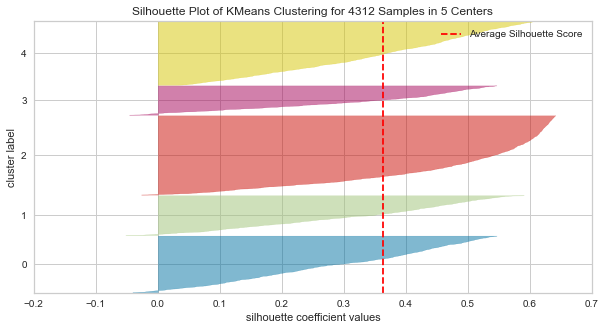

In [12]:
plt.figure(figsize=(10,5))
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

In [13]:
#clusters_results.sort_values(by='KMeans-Cluster')
plot_graph2D(clusters_results['umap_x'],
             clusters_results['umap_y'],
             clusters_results['KMeans-Cluster'],
             title='KMeans Cluster using UMAP')

In [14]:
plot_graph2D(clusters_results['tsne_x'],
             clusters_results['tsne_y'],
             clusters_results['KMeans-Cluster'],
             title='KMeans Cluster using t-SNE')

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hierarchical Clustering</p></div>

In [15]:
hc_scores_list = []

for k in range(2,11):
    tunning_hc = hierarchy.linkage(X, 'ward', metric='euclidean')# init="k-means++",
    
    # We need to test which space (PCA, UMAP, t-SNE) performs best according to WCSS and Silhouette Score metrics
    # component, umap_embedding, tsne_embedding
    # Thus, the space embedding that presented the best results was the UMAP.
    tunning_hc_labels = hierarchy.fcluster(tunning_hc, k, criterion='maxclust')
    
    ss = silhouette_score(X, tunning_hc_labels, metric='euclidean')
    
    dbs = davies_bouldin_score(X, tunning_hc_labels)
    
    hc_scores_list.append(pd.Series({'Clusters': k,
                                    'SS': ss,
                                    'DBS': dbs}))

In [16]:
hc_scores_table = (pd.concat(hc_scores_list, axis=1).T[['Clusters','SS','DBS']].set_index('Clusters'))

In [17]:
hc_scores_table

SS       DBS
Clusters                    
2.0       0.428879  0.876960
3.0       0.312909  0.987920
4.0       0.312047  1.098401
5.0       0.293971  1.062121
6.0       0.302673  0.954654
7.0       0.295164  1.001800
8.0       0.289803  1.040138
9.0       0.247383  1.163983
10.0      0.243285  1.129298

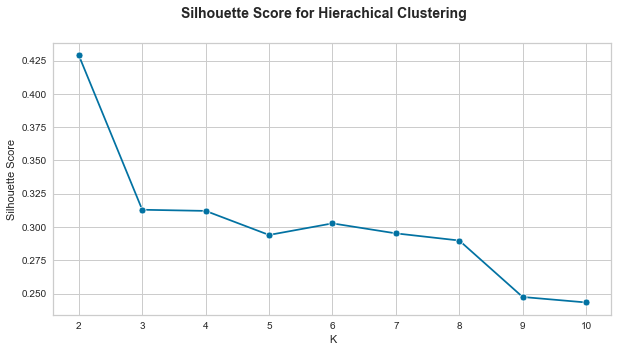

In [18]:
plt.figure(figsize=(10,5))
plt.suptitle('Silhouette Score for Hierachical Clustering', fontsize=14, fontweight='bold')
sns.lineplot(x=hc_scores_table.index, y=hc_scores_table['SS'], marker='o')
plt.xlabel('K');
plt.ylabel('Silhouette Score');

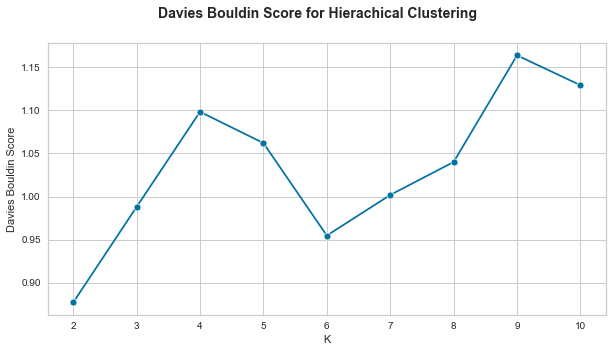

In [19]:
plt.figure(figsize=(10,5))
plt.suptitle('Davies Bouldin Score for Hierachical Clustering', fontsize=14, fontweight='bold')
sns.lineplot(x=hc_scores_table.index, y=hc_scores_table['DBS'], marker='o')
plt.xlabel('K');
plt.ylabel('Davies Bouldin Score');

C:\Users\Alysson\AppData\Local\Temp/ipykernel_2956/721103492.py:21: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



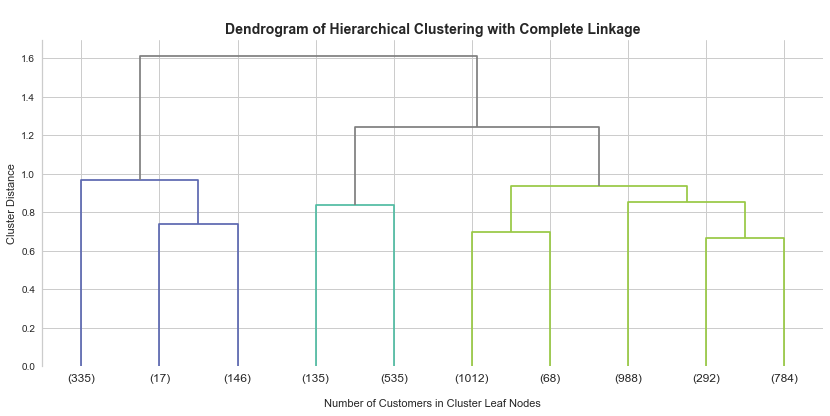

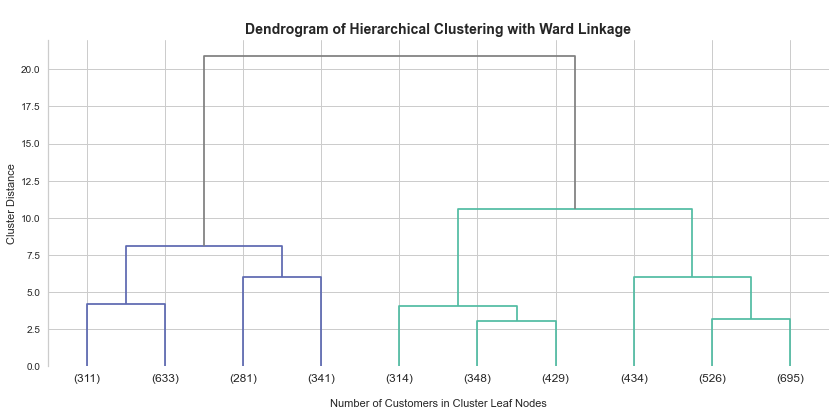

In [20]:
# Finding best K param to Hierachical Clustering, using Dendogram as metric
methods=['complete','ward']

for i in methods:
    Z = hierarchy.linkage(X, method=i, metric='euclidean')
    hierarchy.set_link_color_palette(['#5d69b1', '#52bca3', '#99c945'])

    fig, ax = plt.subplots(figsize=(14,6))
    den=hierarchy.dendrogram(Z, 
                             p=10, 
                             truncate_mode='lastp',
                             show_leaf_counts=True, 
                             ax=ax,
                             above_threshold_color='grey') #orientation='top', #color_threshold=100,
    
    #ax.axhline(10, color='grey', linestyle='--')
    ax.set_title(f'\nDendrogram of Hierarchical Clustering with {i.capitalize()} Linkage', fontweight='bold', fontsize='14')
    ax.set_xlabel('\nNumber of Customers in Cluster Leaf Nodes')
    ax.set_ylabel('Cluster Distance')
    ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False), ax.spines['bottom'].set_visible(False)
    fig.show()
    #plt.savefig(f"..//images//dendogram_{i}.png") 

In [21]:
# Using the best k find to our purpouse

k=10
#hc = AgglomerativeClustering(k, affinity='euclidean', linkage='complete', compute_full_tree=False)
hc = hierarchy.linkage(X, 'ward', metric='euclidean')
hc_labels = hierarchy.fcluster(hc, k, criterion='maxclust')
clusters_results["HierarchicalCluster"]=hc_labels

In [22]:
plot_graph2D(clusters_results['umap_x'],
             clusters_results['umap_y'],
             clusters_results['HierarchicalCluster'],
             title='Hierarchical Cluster using UMAP')

In [23]:
plot_graph2D(clusters_results['tsne_x'],
             clusters_results['tsne_y'],
             clusters_results['HierarchicalCluster'],
             title='Hierarchical Cluster using t-SNE')

In [24]:
# clusters_results.sort_values(by='HierarchicalCluster')

# fig = px.scatter(clusters_results, x="RecencyDays", y="GrossRevenueTotal", color="HierarchicalCluster", 
#                  color_discrete_sequence=px.colors.qualitative.Prism)
# fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
# fig.update_layout(template=temp, title="Hierarchical Cluster Profiles", 
#                   width=700, legend_title='Cluster',
#                   xaxis=dict(title='RecencyDays', showline=True, zeroline=True), 
#                   yaxis=dict(title='GrossRevenueTotal',showline=True))
# fig.show()

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Guassian Mistured Model</p></div>

In [25]:
# Finding best K param to GMM, AIC and BIC as metrics
gmm_scores_list = []

for k in range(2,13):
    tunning_gmm = GaussianMixture(n_components=k, random_state=3456)#n_init=5, init_params='k-means++', 
    tunning_gmm_labels = tunning_gmm.fit_predict(X)
    
    ss = silhouette_score(X, tunning_gmm_labels, metric='euclidean')
    dbs = davies_bouldin_score(X, tunning_gmm_labels)
    
    gmm_scores_list.append(pd.Series({'Clusters': k,
                                    'AIC': tunning_gmm.aic(X),
                                    'BIC': tunning_gmm.bic(X),
                                    'SS': ss, 
                                    'DBS': dbs})) 

In [26]:
gmm_scores_table = (pd.concat(gmm_scores_list, axis=1).T[['Clusters','AIC','BIC','SS','DBS']])#.set_index('Clusters'))  

In [27]:
gmm_scores_table

Clusters           AIC           BIC        SS       DBS
0        2.0 -17710.260742 -17589.246757  0.391779  0.909780
1        3.0 -27139.509691 -26954.804135  0.210130  1.625835
2        4.0 -18895.664411 -18647.267283  0.281246  1.151806
3        5.0 -32826.583759 -32514.495061  0.110722  2.243668
4        6.0 -32794.574501 -32418.794232  0.103534  2.068429
5        7.0 -35825.969604 -35386.497763  0.044964  2.792985
6        8.0 -36316.019437 -35812.856025  0.078922  2.697044
7        9.0 -35879.669799 -35312.814816 -0.069195  1.993543
8       10.0 -33698.395202 -33067.848648  0.099965  2.031565
9       11.0 -39649.322084 -38955.083959 -0.029284  3.562463
10      12.0 -39625.612249 -38867.682552 -0.022802  3.395481

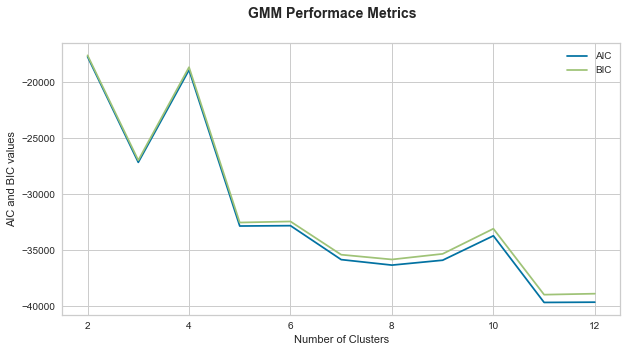

In [28]:
plt.figure(figsize=(10,5))
plt.suptitle('GMM Performace Metrics', fontsize=14, fontweight='bold')
plt.plot(gmm_scores_table.Clusters, gmm_scores_table.AIC, label='AIC')
plt.plot(gmm_scores_table.Clusters, gmm_scores_table.BIC, label='BIC')
plt.ylabel('AIC and BIC values')
plt.xlabel('Number of Clusters')
plt.legend(loc='best')
plt.show()

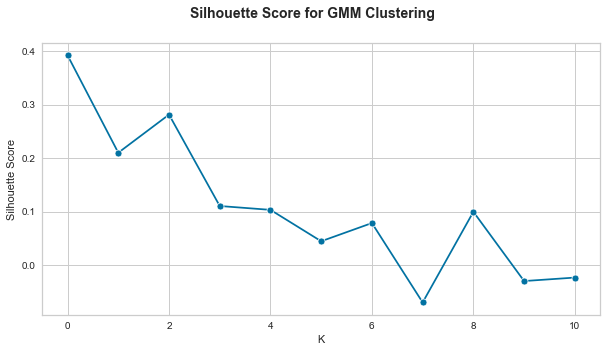

In [29]:
plt.figure(figsize=(10,5))
plt.suptitle('Silhouette Score for GMM Clustering', fontsize=14, fontweight='bold')
sns.lineplot(x=gmm_scores_table.index, y=gmm_scores_table['SS'], marker='o')
plt.xlabel('K');
plt.ylabel('Silhouette Score');

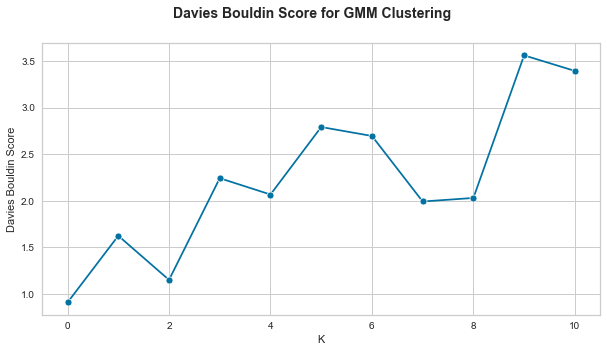

In [30]:
plt.figure(figsize=(10,5))
plt.suptitle('Davies Bouldin Score for GMM Clustering', fontsize=14, fontweight='bold')
sns.lineplot(x=gmm_scores_table.index, y=gmm_scores_table['DBS'], marker='o')
plt.xlabel('K');
plt.ylabel('Davies Bouldin Score');

In [31]:
k=9
gmm = GaussianMixture(n_components=k, random_state=3456)#n_init=5, init_params='k-means++',
gmm_labels = gmm.fit_predict(X)
clusters_results['GMM-Cluster'] = gmm_labels

In [32]:
#clusters_results.sort_values(by='GMM-Cluster')
plot_graph2D(clusters_results['umap_x'],
             clusters_results['umap_y'],
             clusters_results['GMM-Cluster'],
             title='GMM Cluster using UMAP')

In [33]:
plot_graph2D(clusters_results['tsne_x'],
             clusters_results['tsne_y'],
             clusters_results['GMM-Cluster'],
             title='GMM Cluster using t-SNE')

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">DBScan</p></div>

In [34]:
# Using to find outliers
# As our data is very homogeneous, it might not perform well as a classifier, however DBScan is a great algorithm to detect outliers.
eps=0.048
min_samples=7

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)

clusters_results['DBScan-Cluster'] = dbscan_labels
clusters_results['DBScan-Cluster'] = clusters_results['DBScan-Cluster'].astype(str).apply(lambda x: 'Outlier' if x == '-1' else x)
clusters_results['DBScan-Cluster'].value_counts()

0          1657
1          1248
3           741
Outlier     267
2           249
5            86
6            35
4            19
7             7
8             3
Name: DBScan-Cluster, dtype: int64

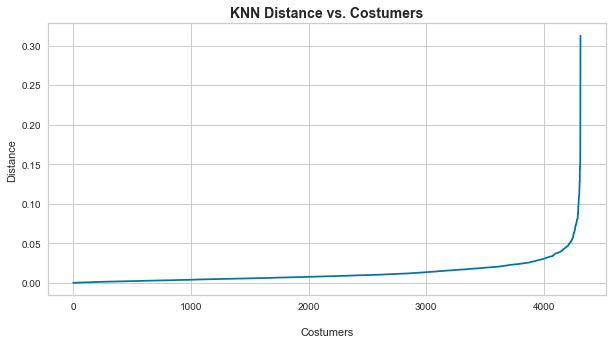

In [35]:
# Finding best epsilon(radious) param to DBScan, AIC and BIC as metrics

knn = NearestNeighbors(n_neighbors=min_samples).fit(X)
distance, costumers = knn.kneighbors(X)
distance = np.sort(distance, axis=0)
distance = distance[:,1]

plt.figure(figsize=(10,5))
plt.title("KNN Distance vs. Costumers", fontweight='bold', fontsize=14)
plt.xlabel('\nCostumers')
plt.ylabel('Distance')
plt.plot(distance);
#best eps is around 0.04~0.05

In [36]:
plot_graph2D(clusters_results['umap_x'],
             clusters_results['umap_y'],
             clusters_results['DBScan-Cluster'],
             title='DBScan Cluster using UMAP')

In [37]:
plot_graph2D(clusters_results['tsne_x'],
             clusters_results['tsne_y'],
             clusters_results['DBScan-Cluster'],
             title='DBScan Cluster using t-SNE')

In [38]:
#clusters_results.sort_values(by='GrossRevenueTotal', ascending=False).tail(50)

In [39]:
# Initializing figure with 3 3D subplots
fig = make_subplots(rows=1, cols=1,
                    specs=[[{'type': 'scatter3d'}]])
                  

# Adding clusters to scatterplots 
clusters_results['HierarchicalCluster'] = clusters_results['HierarchicalCluster'].astype(int)
clusters_results = clusters_results.sort_values(by='HierarchicalCluster')  

for i in range(0,11):
    fig.add_trace(go.Scatter3d(x = clusters_results[clusters_results['HierarchicalCluster'] == i]['Recency'],
                               y = clusters_results[clusters_results['HierarchicalCluster'] == i]['Frequency'],
                               z = clusters_results[clusters_results['HierarchicalCluster'] == i]['GrossRevenue'],                        
                               mode = 'markers', marker=dict(
                                   size=7,  
                                   color = px.colors.qualitative.Prism[i],
                                   line_width = 1,
                                   line_color='#F7F7F7',
                                   opacity=0.7),                               
                               name = str(str(i)), legendgroup = 1),                                                               
                 row=1, col=1)
    
fig.update_traces(hovertemplate='x: %{x} <br>y: %{y} <br>z: %{z}')

fig.update_layout(title="Hierarchical Clusterization",
                  template=temp, height=700, legend_tracegroupgap = 550,
                  legend_title='Clusters',
                  scene=dict(aspectmode='cube',
                             xaxis = dict(title='Recency', 
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='Frequency',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='GrossRevenue', 
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white")))  
fig.show()

#fig.write_image('../images/hc.svg')

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Embedding Space</p></div>

In [40]:
X_prep = X.drop(columns=['GrossRevenue'], axis=1)
y_prep = X['GrossRevenue']

rf = RandomForestRegressor(n_estimators=100, random_state=3456)
rf.fit(X_prep,y_prep)

df_leaf_prep = pd.DataFrame(rf.apply(X_prep))
df_tree_prep = pd.DataFrame()

In [41]:
df_leaf_prep

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14  ...    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99
0     1704  1756  1720  1720  1634  1627  1745  1770  1651  1722  1752  1633  1683  1745  1625  ...  1627  1777  1630  1750  1643  1596  1701  1709  1761  1790  1724  1751  1646  1787  1727
1     1343  1364  1350  1344  1365  1363  1332  1382  1384  1259  1359  1348  1380  1337  1350  ...  1351  1362  1354  1352  1370  1348  1382  1364  1260  1274  1328  1348  1351  1372  1337
2       39    40    40    36    40    40    39    40    45    39    42    35    38    38    36  ...    36    40    39    35    37    33    38    38    39    41    40    36    39    45    42
3      468   464   464   458   471   461   460   470   468   460   477   462   483   464   466  ...   475   468   476   476   472   475   473   462   462   468   470   462   458   471   460
4     1942  1946  1948  1816  1923  1947  1879  1867  1937  1905  1943  1895  1994  1938  1890  ...  1821  1924  1896  1862  1794  1885  1938  1842  1889  1975  1907  1846  1890  1965  1892
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
4307   424   422   424   412   420   420   418   419   425   418   425   415   432   419   420  ...   423   420   428   429   425   428   431   418   417   420   416   416   410   430   419
4308   276   283   289   276   278   281   280   283   280   269   281   278   294   280   274  ...   284   283   277   287   281   279   280   275   274   298   280   281   270   279   276
4309   947   956   962   967   975   976   941   985   972   971   970   970  1000   958   955  ...   963   955   966   963   972   964   993   969   975   976   952   963   954   975   954
4310  2181  2210  2234  2181  2209  2195  2225  2238  2236  2170  2225  2187  2270  2116  2198  ...  2179  2225  2232  2228  2237  2240  2232  2228  2193  2253  2174  2230  2234  2265  2204
4311  1004  1013  1007  1022  1031  1027  1000  1031  1036  1032  1024  1023  1047  1018  1014  ...  1019  1016  1015  1015  1031  1017  1044  1025  1034  1029   997  1022  1006  1031  1004

[4312 rows x 100 columns]

In [42]:
embedding_umap = umap.fit_transform(df_leaf_prep)

df_tree_prep['umap_em_x'] = embedding_umap[:, 0]
df_tree_prep['umap_em_y'] = embedding_umap[:, 1] 

C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

C:\Users\Alysson\anaconda3\lib\site-packages\umap\spectral.py:260: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



In [43]:
#sns.scatterplot(x=df_tree_prep['umap_em_x'], y=df_tree_prep['umap_em_y']);

In [44]:
embedding_tsne = tsne.fit_transform(df_leaf_prep)

df_tree_prep['tsne_em_x'] = embedding_tsne[:, 0]
df_tree_prep['tsne_em_y'] = embedding_tsne[:, 1]

In [45]:
#sns.scatterplot(x=df_tree_prep['tsne_em_x'],y=df_tree_prep['tsne_em_y']);

In [46]:
#embedding from UMAP (first run)
X_em = df_tree_prep[['umap_em_x','umap_em_y']].copy()
#X_em = df_tree_prep[['tsne_em_x','tsne_em_y']].copy()
#X_em = df_tree_prep[['umap_x','umap_y']].copy()
X_em.head()

umap_em_x  umap_em_y
0   0.590398  -3.094881
1  19.064613  -5.426104
2 -18.984022  14.989071
3 -15.860290  -2.599163
4  12.532504   9.852577

In [47]:
clusters_em = np.arange(2,21,1)

In [48]:
kmeans_list = []

for k in clusters_em:
    kmeans_em = KMeans(n_clusters=k, random_state=3456) #init="k-means++", 
    kmeans_em_labels = kmeans_em.fit_predict(X_em)
    kmeans_em_ss = silhouette_score(X_em, kmeans_em_labels, metric='euclidean')
    kmeans_list.append(kmeans_em_ss)

In [49]:
gmm_list = []
for k in clusters_em:
    gmm_em = GaussianMixture(n_components=k, random_state=3456) #n_init=10
    gmm_em_labels = gmm_em.fit_predict(X_em)    
    gmm_em_ss = silhouette_score(X_em, gmm_em_labels, metric='euclidean')
    gmm_list.append(gmm_em_ss)

In [50]:
hc_list = []
for k in clusters_em:
    hc_em = hierarchy.linkage(X_em, 'ward')
    hc_em_labels = hierarchy.fcluster(hc_em, k, criterion='maxclust')#to cut dendrogram    
    hc_ss = silhouette_score(X_em, hc_em_labels, metric='euclidean')
    hc_list.append(hc_ss) 

In [51]:
dbs_list = []
epsilon = np.arange(0.01, 1, 0.01)
for k in epsilon:
    dbs_em = DBSCAN(eps=k, min_samples=10, metric='euclidean')
    dbs_em_labels = dbs_em.fit_predict(X_em)   
    dbs_ss = silhouette_score(X_em, dbs_em_labels, metric='euclidean')
    dbs_list.append(dbs_ss) 

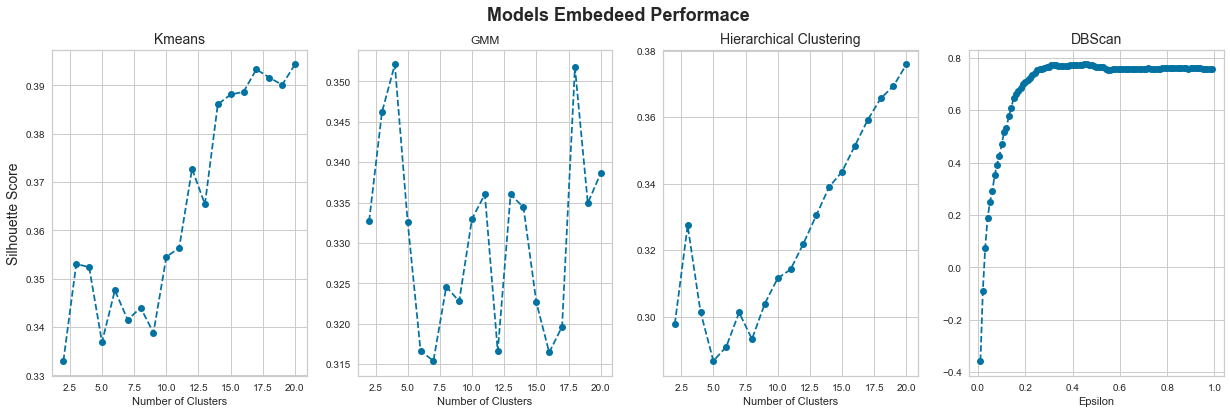

In [52]:
plt.figure(figsize=(21,6))
plt.suptitle("Models Embedeed Performace\n", fontweight='bold', fontsize=18)
# plt.supxlabel('Number of Clusters')
# plt.supylabel('Silhouette Score')
plt.subplot(1, 4, 1)
plt.plot(clusters_em, kmeans_list, linestyle='--', marker='o', color='b')
plt.title("Kmeans", fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.xlabel('Number of Clusters')
plt.subplot(1, 4, 2)
plt.title("GMM")
plt.xlabel('Number of Clusters')
plt.plot(clusters_em, gmm_list, linestyle='--', marker='o', color='b')
plt.subplot(1, 4, 3)
plt.title("Hierarchical Clustering", fontsize=14)
plt.xlabel('Number of Clusters')
plt.plot(clusters_em, hc_list, linestyle='--', marker='o', color='b')
plt.subplot(1, 4, 4)
plt.title("DBScan", fontsize=14)
plt.xlabel('Epsilon')
plt.plot(epsilon, dbs_list, linestyle='--', marker='o', color='b')
plt.show()

In [53]:
# Kmeans
k=10
kmeans_em = KMeans(n_clusters=k, random_state=3456) #max_iter=300, init = "k-means++",
kmeans_em_labels = kmeans_em.fit_predict(X_em)
df_tree_prep['KMeans-Embeeded'] = kmeans_em_labels

In [54]:
k=10
gmm_em = GaussianMixture(n_components=k, n_init=5, init_params='k-means++', random_state=3456) #n_init=10
gmm_em_labels = gmm_em.fit_predict(X_em)  
df_tree_prep['GMM-Embeeded'] = gmm_em_labels

In [55]:
k=10
hc_em = hierarchy.linkage(X_em, 'ward')
hc_em_labels = hierarchy.fcluster(hc_em, k, criterion='maxclust') 
df_tree_prep['HC-Embeeded'] = hc_em_labels

In [56]:
# # Hierarchical clustering
# hc_em = AgglomerativeClustering(8, affinity='euclidean', linkage='complete', compute_full_tree=False)
# hc_em.fit(X_em)
# hc_em_labels = hc_em.labels_
# clusters_results['HC-Embeeded'] = hc_em_labels

In [57]:
eps=25
min_samples=15

dbs_em = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbs_em_labels = dbs_em.fit_predict(X_em)
df_tree_prep['DBScan-Embeeded'] = dbs_em_labels

<AxesSubplot:xlabel='umap_em_x', ylabel='umap_em_y'>

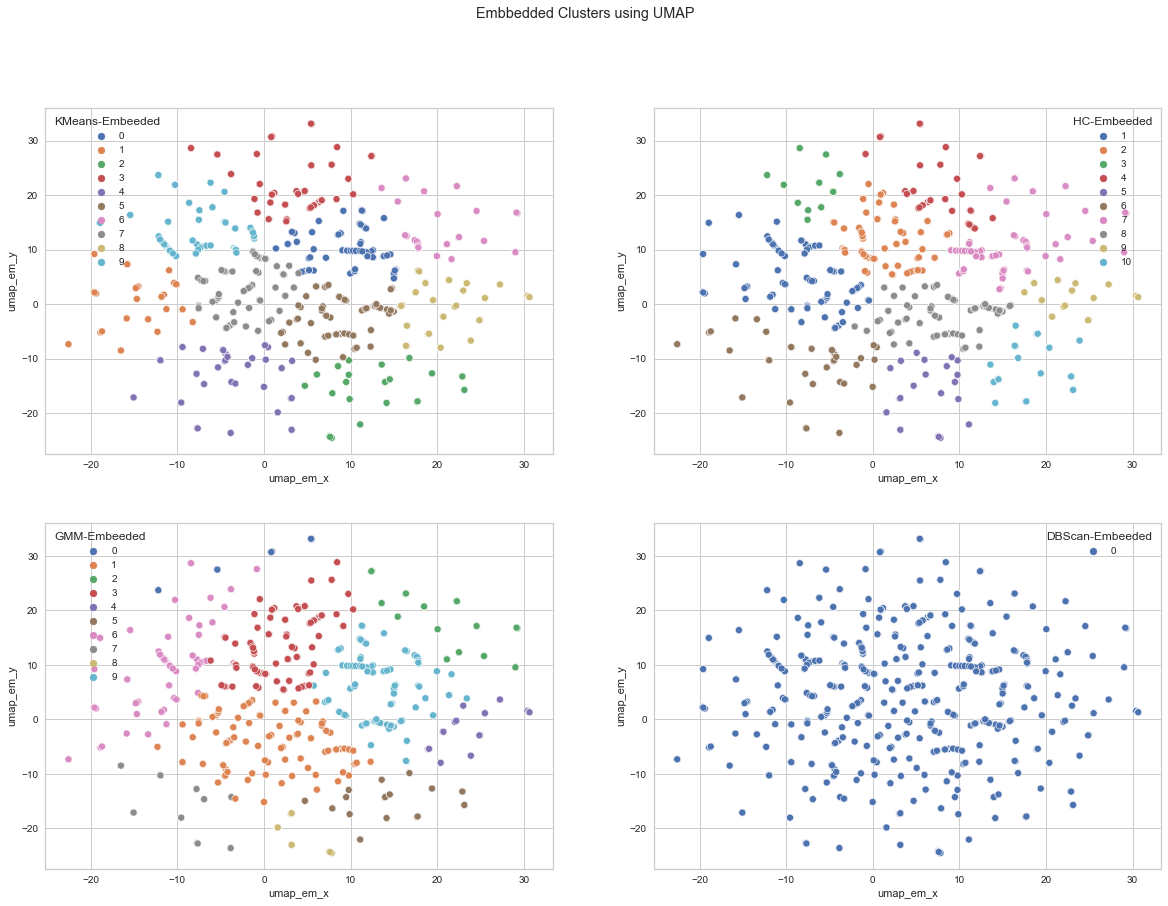

In [58]:
plt.figure(figsize=(20,14))
plt.suptitle('Embbedded Clusters using UMAP')
plt.subplot(2, 2, 1)
sns.scatterplot(x='umap_em_x', y='umap_em_y', hue='KMeans-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 2)
sns.scatterplot(x='umap_em_x', y='umap_em_y', hue='HC-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 3)
sns.scatterplot(x='umap_em_x', y='umap_em_y', hue='GMM-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 4)
sns.scatterplot(x='umap_em_x', y='umap_em_y', hue='DBScan-Embeeded', data=df_tree_prep, palette='deep')

<AxesSubplot:xlabel='tsne_em_x', ylabel='tsne_em_y'>

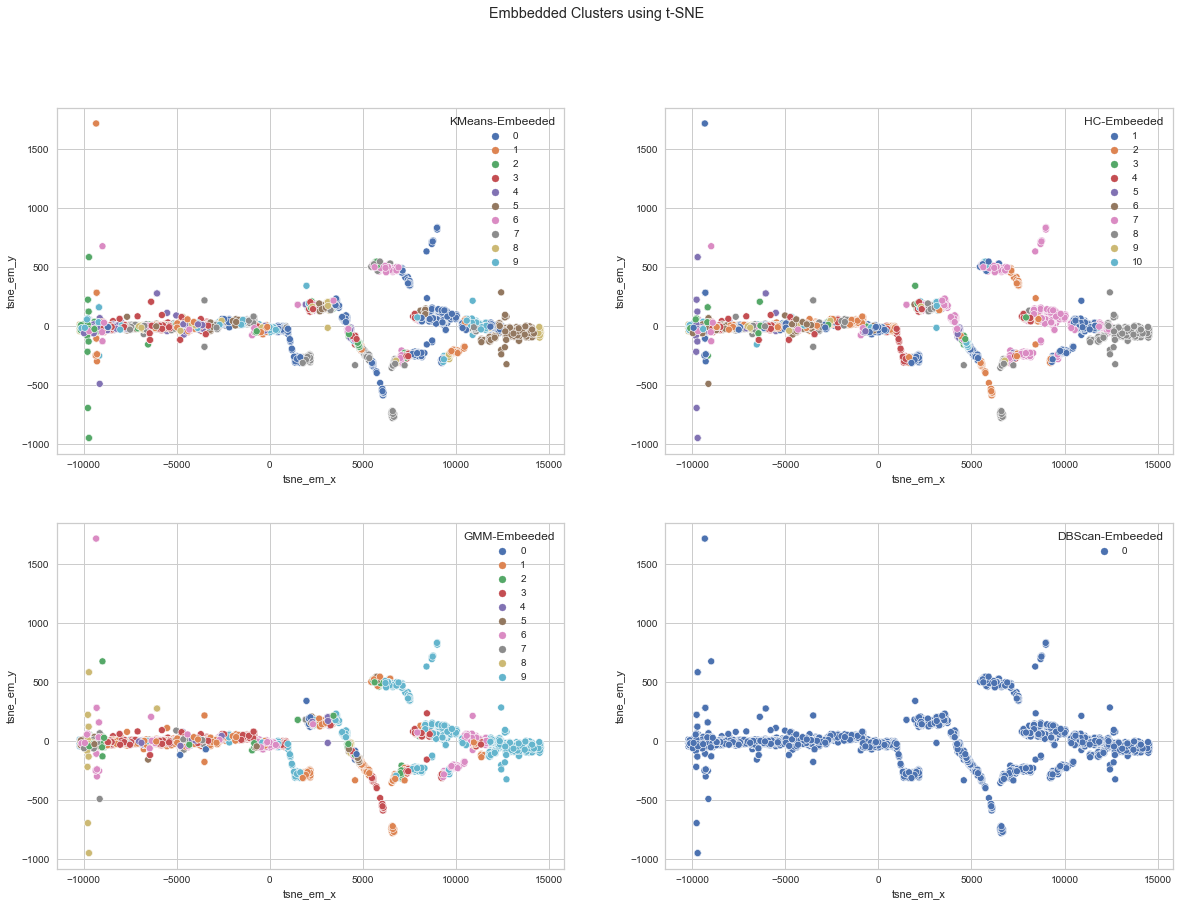

In [59]:
#TSNE Embedded

plt.figure(figsize=(20,14))
plt.suptitle('Embbedded Clusters using t-SNE')
plt.subplot(2, 2, 1)
sns.scatterplot(x='tsne_em_x', y='tsne_em_y', hue='KMeans-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 2)
sns.scatterplot(x='tsne_em_x', y='tsne_em_y', hue='HC-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 3)
sns.scatterplot(x='tsne_em_x', y='tsne_em_y', hue='GMM-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 4)
sns.scatterplot(x='tsne_em_x', y='tsne_em_y', hue='DBScan-Embeeded', data=df_tree_prep, palette='deep')

In [60]:
# knn = NearestNeighbors(n_neighbors=min_samples).fit(X)
# distance, costumers = knn.kneighbors(X)
# distance = np.sort(distance, axis=0)
# distance = distance[:,1]

# plt.figure(figsize=(10,5))
# plt.title("KNN Distance vs. Costumers", fontweight='bold', fontsize=14)
# plt.xlabel('\nCostumers')
# plt.ylabel('Distance')
# plt.plot(distance);
# #best eps is around 0.04~0.05

## Evaluating

In [61]:
#data_client_resume['Cluster'] = kmeans_em_labels
#data_client_resume['Cluster'] = hc_em_labels

In [62]:
all_clusters=transactions_per_customer.copy()


all_clusters['KM'] = kmeans_labels
all_clusters['KME'] = kmeans_em_labels

all_clusters['HC'] = hc_labels
all_clusters['HCE'] = hc_em_labels

all_clusters['GMM'] = gmm_labels
all_clusters['GMME'] = gmm_em_labels

all_clusters['DB'] = dbscan_labels
all_clusters['DBE'] = dbs_em_labels

In [63]:
all_clusters[['GrossRevenue','Recency','Frequency','HC']].groupby('HC').mean().sort_values(by='GrossRevenue', ascending=False).head(20)

GrossRevenue     Recency  Frequency
HC                                     
3   13793.701210    6.370107  25.982206
1    3713.345916   42.475884  10.581994
2    1678.157504   18.075829   5.451817
8    1529.239724  113.877880   4.467742
4    1522.371525    3.662757   5.351906
6     802.785489   39.525862   2.974138
9     641.665171  196.627376   2.110266
7     363.514452   60.165501   1.289044
5     298.804777   19.449045   1.512739
10    211.053914  239.513669   1.043165

In [64]:
report = all_clusters[['GrossRevenue','Recency','Frequency','HC']].groupby('HC').agg( MonetarySum = ('GrossRevenue', 'sum'),
                                             MonetaryMean = ('GrossRevenue', 'mean'),
                                             Recency = ('Recency', 'mean'),
                                             Frequency = ('Frequency', 'mean'),
                                             Count = ('GrossRevenue', 'count')).reset_index()

report['Percentage'] = round((report['Count'] / report['Count'].sum()*100),2)
report=report.sort_values(by='MonetaryMean', ascending=False)

In [65]:
report['Cluster'] = ['Champion', #3
                     'Loyal Costumer', #4
                     'Potential Loyalist',#1
                     'Cannot Lose Them', #7 
                     'New Customers', #9
                     'Promising', #5
                     'About to Sleep',    #2               
                     'Need Atention', #10
                     'At Risk',   #8
                     'Hinernating']   #6

In [66]:
report.set_index('Cluster', inplace=True)
report.drop('HC', axis=1,inplace=True)

In [67]:
cm = sns.light_palette("#A2A2A2", as_cmap = True)

report=report.style.background_gradient(cmap = cm, axis = 0)\
    .set_precision(2)\
    .highlight_min(axis = 0, color = "#FF6347")\
    .highlight_max(axis = 0, color = "#2F4F4F")

report

In [68]:
di.export(report,'../images/rfm_ml_table.png')

SyntaxError: not a PNG file (<string>)

In [ ]:
transactions_per_customer['Segment'] = hc_labels

In [ ]:
hc_map = { 3:'Champions', 
           4:'Loyal Customers',
           1:'Potential Loyalists',
           7:'Cannot Lose Them', 
           9:'Promising',
           5:'At Risk',
           2:'New Customers',
           10:'Need Attention',
           8:'About to Sleep',
           6:'Hinernating'}

transactions_per_customer['Segment'].replace(hc_map, inplace=True)

In [ ]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot Lose Them": [4, 5, 0, 0.4],
                   "At Risk": [2, 4, 0, 0.4],
                   "Hinernating": [0, 2, 0, 0.4],
                   "About to Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

In [ ]:
rfm=transactions_per_customer.copy()

In [ ]:
rfm.groupby('Segment').mean().sort_values(by='GrossRevenueTotal', ascending=False).head(20)

In [ ]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"

palette = ["#DAA520", "#A0522D", "#8B0000", "#F1480F",  "#EE82EE", 
           "#C71585", "#A020F0", "#7B68EE", "#4B0082", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]

    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm[rfm.Segment == key].shape[0]
    users_percentage = (rfm[rfm.Segment == key].shape[0] / rfm.shape[0]) * 100
    avg_monetary = rfm[rfm.Segment == key]["GrossRevenue"].mean()
    
    user_txt = "\n\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score", fontsize=14)
    ax.set_ylabel("Frequency Score", fontsize=14)
    
sns.despine(left = True, bottom = True)

plt.title('RFM Segment using, Machine Learning\n', fontsize='21', fontweight='bold')
plt.savefig("..//images//rfm_ml.png")
plt.show()